# Exercise 1: random walk

1. Write a function `randomwalk` that simulates `N` random walks for `tmax` time steps, each walk starting at zero
2. Plot all walks on the same plot
3. Plot walk endpoints on a histogram, determine how `tmax` affects the distribution

In [1]:
## 1. Define function
randomwalk <- function(N, tmax) {
  m <- matrix(nrow = N, ncol = tmax)  # Create empty matrix to store walks in
  m[,1] <- 0  # Assign first column of matrix to 0
  for (row in 1:N) {
    for (col in 2:tmax) {
      m[row, col] <- m[row, col-1] + rnorm(1)  # Insert value of x into the appropriate matrix position
    }  # Loop through range of tmax
  }  # Loop through range of N
  return(m)  # Return matrix
}

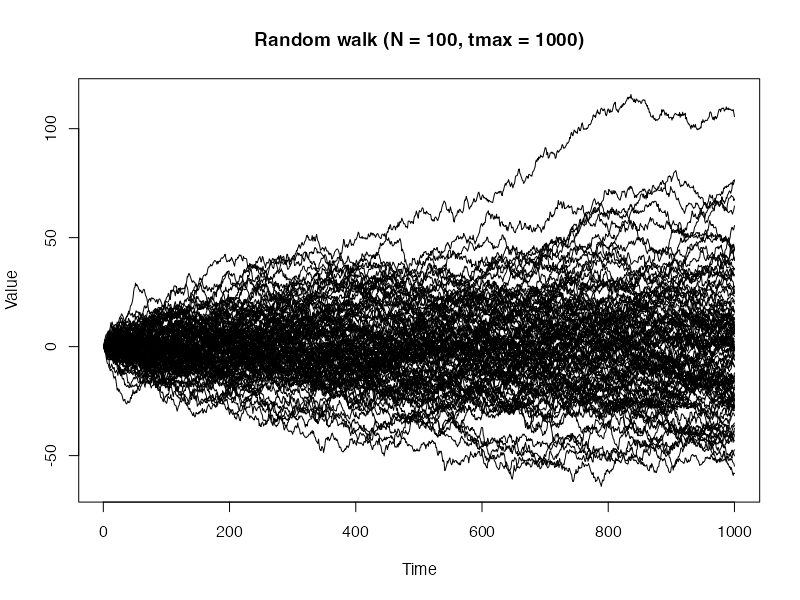

In [15]:
## 2. Plot
set.seed(0)  # Set random seed
N <- 100  # Assign N
tmax <- 1000  # Assign tmax
m <- randomwalk(N, tmax)  # Run function randomwalk to generate matrix
par(mfrow = c(1, 1))  # Force 1 subplot
plot(
  m[1,], type = "l", ylim = c(min(m), max(m)), main = paste0("Random walk (N = ", N, ", tmax = ", tmax, ")"),
  xlab = "Time", ylab = "Value"
)  # Plot the first row of the matrix using plot
for (row in 2:N) {
  points(m[row,], type = "l")  # Plot each row as a line
}  # Loop through the rest of the matrix rows

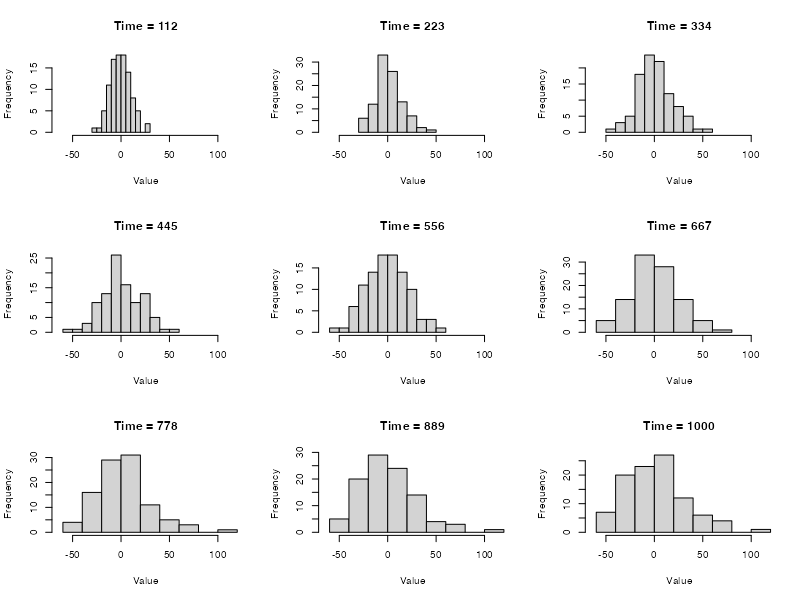

In [ ]:
## 3. Plot endpoints on histogram
par(mfrow = c(3, 3))  # Force 9 subplots
t_intervals <- seq(1, tmax, length = 10)[-1]  # Get 9 evenly spaced time intervals from tmax
for (t in t_intervals) {
  hist(
    m[, t], xlim = c(min(m), max(m)),
    main = paste0("Time = ", t), xlab = "Value"
  )  # Plot each histogram
}  # Loop through time intervals